# Book Recommender System 
### Pavel Novotný - 18. 05. 2022

The goal is to build a recommender system that will give book recommendations a reader might be interested in.

Dataset I'm working with: `Book Crossing Dataset` http://www2.informatik.uni-freiburg.de/~cziegler/BX/

Consits of 3 CSV files: `BX-Users`, `BX-Books` and `BX-Book-Ratings`


#### The script implements the following 2 methods of a recommender system:
* item-based collaborative filtering
* model-based CF using latent factors via SVD matrix factorization 

For each of these 2 approaches, 2 options were implemented as described later.

### Package import and data load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

I eventually ran into problems loading BX-Books dataset, the problem is that some rows include semicolon in the title name, which is also the csv separator of the file. Since it is only 20 rows, I ignore those.

In [2]:
users = pd.read_csv('./BX-CSV-Dump/BX-Users.csv', sep=';', encoding='iso-8859-1')
books = pd.read_csv('./BX-CSV-Dump/BX-Books.csv', sep=';', encoding='iso-8859-1',on_bad_lines='skip',dtype=object)
ratings = pd.read_csv('./BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', encoding='iso-8859-1')

# 1. Exploratory Data Analysis

How many rows were successfuly loaded in with skipping bad lines? Seems only 20 rows failed to load in, ignoring those for the moment. (Compared the CSV size manually in VS code)

In [3]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


#### Am I dealing with missing values?

In [4]:
print("missing values: users")
print(users.isna().sum())
print()
print("missing values: books")
print(books.isna().sum())
print()
print("missing values: ratings")
print(ratings.isna().sum())


missing values: users
User-ID          0
Location         0
Age         110762
dtype: int64

missing values: books
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

missing values: ratings
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


#### How are the ratings distributed?

In [5]:
ratings['Book-Rating'].describe().apply(lambda x: format(x, 'f'))

count    1149780.000000
mean           2.866950
std            3.854184
min            0.000000
25%            0.000000
50%            0.000000
75%            7.000000
max           10.000000
Name: Book-Rating, dtype: object

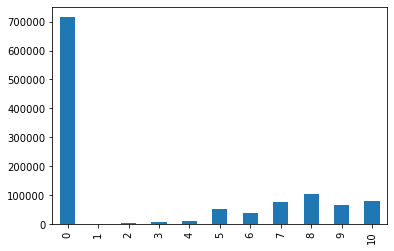

In [6]:
#sort_index() to print bars sorted from 0 to 10
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.show()

There's a significant number of ***implicit*** ratings (rating=0, as the data source describes). These have a different interpretation than ***explicit*** ratings <1-10>, it is necessary to separate them (as is done later in data preparation).

In [7]:
ratings['Book-Rating'].value_counts().sort_index()

0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: Book-Rating, dtype: int64

### Age of users

I won't be using age as a feature since I'm doing a collaborative filtering models, but let's look into the data anyway. There is also quite a lot of missing values of age, if I were using age as a feature, missing value imputation would be necessary (e.g. median or mean, plus adding a binary label imputed: 0/1)

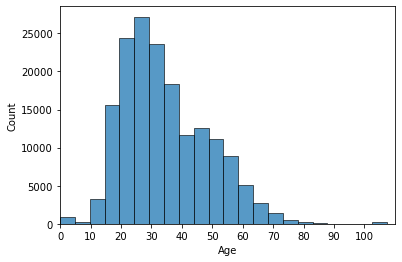

In [8]:
sns.histplot(data=users,x='Age',bins=50)
plt.xlim(0, 110)
plt.xticks(np.arange(0,101,step=10))
plt.show()

### Year of Publication

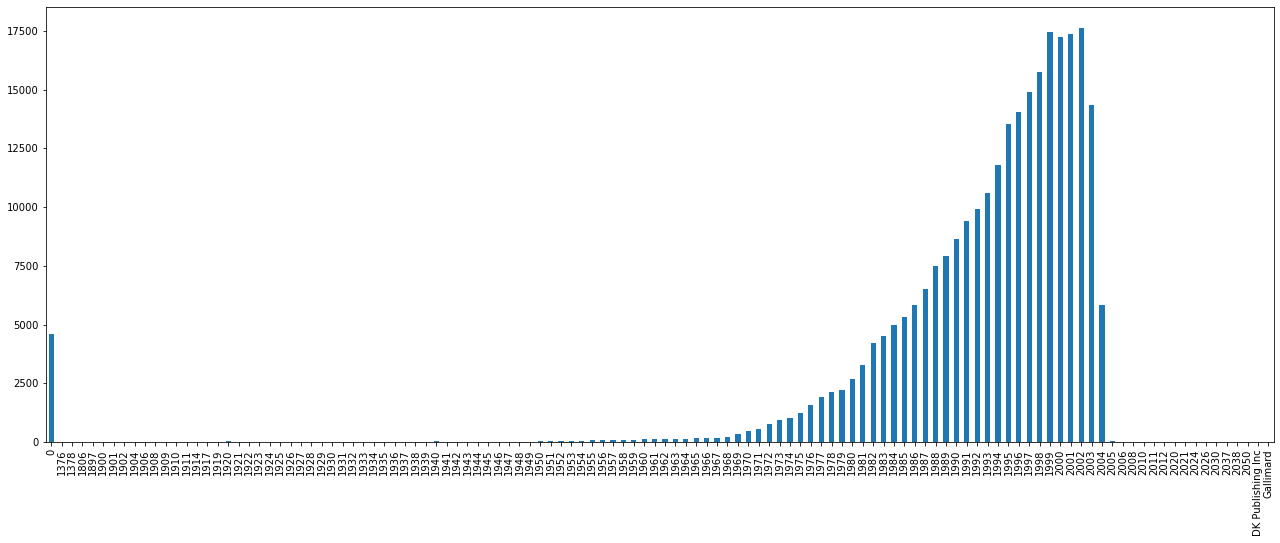

In [9]:
books['Year-Of-Publication'].value_counts().sort_index().plot(kind='bar',figsize=(22, 8))
plt.show()

How many books have no rating?

In [10]:
print(books.loc[~ratings['ISBN'].isin(books['ISBN'])].shape[0] / books.shape[0])

0.1044921875


### Count of ratings per books

In [11]:
rating_counts_eda = ratings.groupby(by='ISBN')['Book-Rating'].count().reset_index()
rating_counts_eda = rating_counts_eda.rename(columns={'Book-Rating':'rating_counts'})
rating_counts_eda.describe()

,rating_counts
count,340556.000000
mean,3.376185
std,12.436252
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2502.000000


Books get 3.4 ratings on average, but this is affected by the extreme values. For computation complexity reasons, I decided to include only movies with number of ratings >= 10. (See data preparation)

### Count of ratings per user

In [12]:
rating_counts_eda_user = ratings.groupby(by='User-ID')['Book-Rating'].count().reset_index()
rating_counts_eda_user = rating_counts_eda_user.rename(columns={'Book-Rating':'rating_user_count'})
rating_counts_eda_user[['rating_user_count']].describe()

,rating_user_count
count,105283.000000
mean,10.920851
std,90.562825
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,13602.000000


# 2. Data preparation

* Dropping the image urls columns, won't be needed (at least at the moment)
* Renaming columns for easier typing

In [13]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

books = books.rename(columns={'ISBN':'isbn', 'Book-Title':'title','Book-Author':'author',
                      'Year-Of-Publication':'year','Publisher':'publisher'})

ratings = ratings.rename(columns={'User-ID':'user_id', 'ISBN':'isbn', 'Book-Rating':'rating'})

users = users.rename(columns={'User-ID':'user_id', 'Location':'location', 'Age': 'age'})

3 rows in the books dataframe (df shape vs shape of the following result) actually did not contain correct year value -> dropping those

In [14]:
print(books.shape)
books = books[pd.to_numeric(books['year'], errors='coerce').notnull()]
books['year'] = books['year'].astype(int)
print(books.shape)

(271360, 5)
(271357, 5)


#### Split ratings dataset to implicit and explicit rating subsets, build RS only with explicit ratings

In [15]:
#implicit
ratings_0 = ratings.loc[ratings['rating']==0]
#explicit
ratings_1_10 = ratings.loc[(ratings['rating']>=1) & (ratings['rating']<=10)]

#### Merge books with explicit ratings

In [16]:
book_rating = books.merge(ratings_1_10,how='inner', on='isbn')
book_rating.head()

,isbn,title,author,year,publisher,user_id,rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866,9
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,123629,9


### Let's calculate the count of ratings and keep only books with at least 10 ratings, so that the dataset isn't that massive

pros: Better performance, but worse recommendation 

cons: We keep recommending the same popular books (but that's a problem of long tail distributions in general I suppose)

In [17]:
rating_counts = book_rating.groupby(by='isbn')['rating'].count().reset_index()
rating_counts = rating_counts.rename(columns={'rating':'rating_counts'})

print(rating_counts.sort_values('rating_counts',ascending=False))

              isbn  rating_counts
21945   0316666343            707
117744  0971880107            581
38819   0385504209            487
18058   0312195516            383
4131    0060928336            320
...            ...            ...
63116   0553100130              1
63110   0553099817              1
63109   0553099809              1
63107   0553099744              1
149834  B000234N3A              1

[149835 rows x 2 columns]


Repeating EDA step (but for the context)

In [18]:
rating_counts[['rating_counts']].describe()

,rating_counts
count,149835.000000
mean,2.561758
std,7.505586
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,707.000000


How many recommendations in the higher percentiles? 1% of books gets more than 24 recommendations. Keeping >=10 is  ***3%*** of books

In [19]:
rating_counts['rating_counts'].quantile(np.arange(0.8, 1, 0.01))

0.80     2.0
0.81     2.0
0.82     3.0
0.83     3.0
0.84     3.0
0.85     3.0
0.86     3.0
0.87     3.0
0.88     4.0
0.89     4.0
0.90     4.0
0.91     5.0
0.92     5.0
0.93     6.0
0.94     6.0
0.95     7.0
0.96     9.0
0.97    11.0
0.98    15.0
0.99    24.0
Name: rating_counts, dtype: float64

#### Filter out the rating of books with >= 10 ratings and merge with rating dataframe

In [20]:
rating_counts = rating_counts.loc[rating_counts['rating_counts']>=10]
book_rating_10plus = rating_counts.merge(book_rating,on='isbn',how='inner')

book_rating_10plus = book_rating_10plus.drop_duplicates(['user_id','title'])
book_rating_10plus.head(15)

,isbn,rating_counts,title,author,year,publisher,user_id,rating
0,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,11676,8
1,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,71837,10
2,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,81274,8
3,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,131398,9
4,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,191521,9
5,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,196118,8
6,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,201537,8
7,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,202664,8
8,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,216420,5
9,0002558122,10,Angelas Ashes,Frank Mccourt,0,Harpercollins Australia,236173,9


### Utility matrix preparation

**Flaw**: I used book title as index instead of ISBN (I only realized at the end of the task that some titles might not be unique). If I did it over again, I would pivot by ISBN and later would figure out the mapping the recommendations of ISBN to its book title.

In [21]:
# length: 4843
print("unique titles: ",book_rating_10plus['title'].drop_duplicates().shape[0])
# length: 5444
print("unique ISBNs: ", book_rating_10plus['isbn'].drop_duplicates().shape[0])

unique titles:  4843
unique ISBNs:  5444


#### It's necessary to center the user vectors by substracting the row mean (because cosine similarity would treat the 0 values as negative rating)

In [22]:
pivot = book_rating_10plus.pivot_table(columns='user_id', index='title', values="rating")
pivot = pivot.sub(pivot.mean(axis=1), axis=0)
pivot = pivot.fillna(0)

#### Check that the row vectors are centered:

In [23]:
pivot.mean(axis=1).apply(lambda x: format(x, 'f'))

title
'Salem's Lot                                                                 -0.000000
10 Lb. Penalty                                                                0.000000
100 Selected Poems by E. E. Cummings                                         -0.000000
14,000 Things to Be Happy About                                              -0.000000
16 Lighthouse Road                                                            0.000000
                                                                               ...    
\O\" Is for Outlaw"                                                          -0.000000
\Surely You're Joking, Mr. Feynman!\": Adventures of a Curious Character"     0.000000
e                                                                             0.000000
iI Paradiso Degli Orchi                                                      -0.000000
stardust                                                                      0.000000
Length: 4843, dtype: object

## Approach 1: Item-based collaborative filtering 
Using the centered cosine similarity (Pearson coefficient). Returning recommendations based on book title input

#### Implemented using:
1. Cosine_similarity
2. KNearestNeighbors

### Option 1: cosine_similarity (item-item)

In [24]:
sim_matrix = cosine_similarity(pivot)
sim_matrix_df = pd.DataFrame(sim_matrix, index=pivot.index, columns=pivot.index)

def get_recommendations_01(book_index, sim_matrix_df, n=20):
    if book_index in sim_matrix_df.index:

        cosine_sim_series = sim_matrix_df.loc[book_index]
        sorted_similarities = cosine_sim_series.sort_values(ascending=False)
        print('Book recommendations for {0}:\n'.format(book_index))
        print (sorted_similarities[1:n+1])
        
    else: print("This book is not in the dataset")

#### Recommendation examples

In [25]:
get_recommendations_01('1984', sim_matrix_df,n=20)
print('\n')
get_recommendations_01("The Catcher in the Rye",sim_matrix_df,n=20)
print('\n')
get_recommendations_01("Fahrenheit 451", sim_matrix_df, n=20)

Book recommendations for 1984:

title
A Brief History of Time : The Updated and Expanded Tenth Anniversary Edition    0.160000
Days Are Just Packed : A Calvin and Hobbes Collection (Calvin and Hobbes)       0.155354
The Calvin and Hobbes Tenth Anniversary Book                                    0.152781
Brave New World                                                                 0.129677
Animal Farm                                                                     0.120229
Attack Of The Deranged Mutant Killer Snow Goons                                 0.116664
The Rosewood Casket                                                             0.108717
Wherever You Go, There You Are : Mindfulness Meditation in Everyday Life        0.104183
The Adventures of Huckleberry Finn (Penguin Classics)                           0.093534
Even Cowgirls Get the Blues                                                     0.093354
Special Delivery: A Novel                                               

### Option 2: KNearestNeighbors

I'll be using sparse matrix to optimize performance

I'm using brute force algorithm, centered cosine similarity (=pearson coeff.) as my distance metric, with default number of neighbors = 10

In [26]:
utility_matrix = csr_matrix(pivot.values)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute',n_neighbors=10)
model_knn.fit(utility_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [27]:
def get_recommendations_knn(book_index):
    if book_index in pivot.index.get_level_values('title'):
        distances, indices = model_knn.kneighbors(pivot.loc[book_index, :].values.reshape(1, -1),n_neighbors=20)

        for i in range(0, len(distances.flatten())):
            if i == 0: #the chosen book itself always comes as the first in the list
                print('Recommendations for {0}:\n'.format(book_index))
            else:
                print('{0}: {1}, with distance of {2}:'.format(i, pivot.index[indices.flatten()[i]],
                                                           distances.flatten()[i]))
    else: print("This book is not in the dataset")

#### Recommendations examples:

In [28]:
get_recommendations_knn("1984")
print('\n')
get_recommendations_knn("Fahrenheit 451")
print('\n')
get_recommendations_knn("The Catcher in the Rye")

Recommendations for 1984:

1: A Brief History of Time : The Updated and Expanded Tenth Anniversary Edition, with distance of 0.8400004725154684:
2: Days Are Just Packed : A Calvin and Hobbes Collection (Calvin and Hobbes), with distance of 0.8446456388543221:
3: The Calvin and Hobbes Tenth Anniversary Book, with distance of 0.8472186605454852:
4: Brave New World, with distance of 0.8703234920700691:
5: Animal Farm, with distance of 0.8797710665073801:
6: Attack Of The Deranged Mutant Killer Snow Goons, with distance of 0.8833356270752649:
7: The Rosewood Casket, with distance of 0.8912827611054058:
8: Wherever You Go, There You Are : Mindfulness Meditation in Everyday Life, with distance of 0.8958172137902383:
9: The Adventures of Huckleberry Finn (Penguin Classics), with distance of 0.9064664095111754:
10: Even Cowgirls Get the Blues, with distance of 0.906645982598077:
11: Special Delivery: A Novel, with distance of 0.914396255806775:
12: The Grapes of Wrath (20th Century Classics), 

## Approach 2: Matrix Factorization with SVD 

### Option 1: TruncatedSVD and getting the top N most similar books (15 latent factors)

In [29]:
X = pivot.values

SVD = TruncatedSVD(n_components=15, random_state=42)
matrix = SVD.fit_transform(X)
corr = np.corrcoef(matrix)

book_titles = pivot.index
books_list = list(book_titles)

/Users/Pavel/opt/anaconda3/envs/books/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Pavel/opt/anaconda3/envs/books/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [37]:
matrix.shape

(4843, 15)

In [30]:
def get_recommendations_svd(book, n_recommendations=20):
    if book in books_list:
        book_index = books_list.index(book)
        corr_book_index = corr[book_index]
        predictions_svd = pd.DataFrame(book_titles,corr_book_index).reset_index()
        predictions_svd = predictions_svd.rename(columns={'index':'similarity'})
        predictions_svd = predictions_svd.sort_values('similarity', ascending=False)
        predictions_svd = predictions_svd.reset_index(drop=True)
        return predictions_svd.iloc[1:n_recommendations+1,:]
    else: print("The book isn't in the dataset.")

In [31]:
print("Recommendations for 1984: \n", get_recommendations_svd("1984"))
print("\n")
print("Recommendations for Fahrenheit 451: \n", get_recommendations_svd("Fahrenheit 451"))
print("\n")
print("The Catcher in the Rye: \n", get_recommendations_svd("The Catcher in the Rye"))

Recommendations for 1984: 
     similarity                                              title
1     0.911319                                 The Mosquito Coast
2     0.877520                                    Brave New World
3     0.873380                            The Club Dumas: A Novel
4     0.868467  The Alchemist: A Fable About Following Your Dream
5     0.858243                                      Cryptonomicon
6     0.847466  The Reptile Room (A Series of Unfortunate Even...
7     0.843249                                The Handmaid's Tale
8     0.836346                      The Girl Who Loved Tom Gordon
9     0.830189       House Atreides (Dune: House Trilogy, Book 1)
10    0.826817                                Manhattan Hunt Club
11    0.826211  The Sorcerer's Companion: A Guide to the Magic...
12    0.818536                           The Wishsong of Shannara
13    0.817781                   East of Eden (Oprah's Book Club)
14    0.814722                                Th

### Option 2: Getting latent factors via SVD (scipy svds) and predicting ratings for each user, then recommending the top 20 rated books for each

In [32]:
pivot_user = book_rating_10plus.pivot_table(index='user_id', columns='title', values="rating")

#center the utility matrix and fill missing values
user_ratings_mean = pivot_user.mean(axis=1)
pivot_user = pivot_user.sub(user_ratings_mean, axis=0)
pivot_user = pivot_user.fillna(0)

#### Here I worked with 15 latent factors, but grid search would be the best to find the optimal k

In [33]:
U, sigma, Vt = svds(pivot_user, k=15)

sigma = np.diag(sigma)

U_sigma = np.dot(U, sigma)
U_sigma_Vt = np.dot(U_sigma, Vt)

#decentering the ratings back so that the values are interpretable again
predicted_ratings = U_sigma_Vt + user_ratings_mean.values.reshape(-1, 1)
predicted_ratings_df= pd.DataFrame(predicted_ratings, index=pivot_user.index, columns=pivot_user.columns)

#### Calculating RMSE to "evaluate" the recommendations

In [34]:
# getting the initial utility matrix (raw before centering)
pivot_nans = book_rating_10plus.pivot_table(index='user_id', columns='title', values="rating")

actual_values = pivot_nans.values
predicted_values = predicted_ratings_df.values

# Only consider the non-missing values
mask = ~np.isnan(actual_values)

print("Root mean sq. error: ", mean_squared_error(actual_values[mask], predicted_values[mask], squared=False))

Root mean sq. error:  1.2283387248045692


In [35]:
predicted_ratings_df.head()

title,'Salem's Lot,10 Lb. Penalty,100 Selected Poems by E. E. Cummings,"14,000 Things to Be Happy About",16 Lighthouse Road,1984,1st to Die: A Novel,2001: A Space Odyssey,2010: Odyssey Two,203 Ways to Drive a Man Wild in Bed,...,Zen in the Art of Writing,Zodiac: The Eco-Thriller,Zombies of the Gene Pool,Zoya,ZwÃ?Â¶lf.,"\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",e,iI Paradiso Degli Orchi,stardust
user_id,,,,,,,,,,,,,,,,,,,,,
9,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000
16,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
17,4.500013,4.499977,4.500011,4.499937,4.499857,4.499999,4.500781,4.499999,4.500007,4.499909,...,4.500010,4.499994,4.499994,4.499999,4.500003,4.500261,4.500002,4.500049,4.50000,4.499995
19,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000
26,9.499902,9.499677,9.500372,9.500057,9.499817,9.508800,9.496884,9.499694,9.490535,9.496956,...,9.499954,9.499934,9.500023,9.499401,9.500018,9.497902,9.500330,9.500464,9.49999,9.499972


### Top 20 predicted ratings (recommendations) for each user
This might include the books user has already read though. Would be ideal to filter out.

In [36]:
predicted_ratings_top = pd.DataFrame(predicted_ratings_df.apply(lambda x:list(predicted_ratings_df.columns[np.array(x).argsort()[::-1][:20]]), axis=1).to_list())
predicted_ratings_top.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,stardust,Hemlock Bay,Her Daughter's Eyes,Her Father's House,Here on Earth,Here on Earth (Oprah's Book Club),"Heretics of Dune (Dune Chronicles, Book 5)","Herr Der Fliegen (Fiction, Poetry and Drama)",Herr Lehmann.,Herzsprung,"Hidden Agendas (Tom Clancy's Net Force, No. 2)",Hidden Fires,Hidden Jewel (Landry),Hidden Prey,Hidden Riches,Hidden Star (The Stars Of Mithra) (Harlequin ...,Hidden Star (The Star Series),"Henry and June: From \A Journal of Love\"" -The...","Hello, Darkness",Hideaway
1,stardust,Hemlock Bay,Her Daughter's Eyes,Her Father's House,Here on Earth,Here on Earth (Oprah's Book Club),"Heretics of Dune (Dune Chronicles, Book 5)","Herr Der Fliegen (Fiction, Poetry and Drama)",Herr Lehmann.,Herzsprung,"Hidden Agendas (Tom Clancy's Net Force, No. 2)",Hidden Fires,Hidden Jewel (Landry),Hidden Prey,Hidden Riches,Hidden Star (The Stars Of Mithra) (Harlequin ...,Hidden Star (The Star Series),"Henry and June: From \A Journal of Love\"" -The...","Hello, Darkness",Hideaway
2,The Notebook,Harry Potter and the Prisoner of Azkaban (Book 3),Harry Potter and the Chamber of Secrets (Book 2),Harry Potter and the Sorcerer's Stone (Harry P...,The Secret Life of Bees,Harry Potter and the Goblet of Fire (Book 4),Harry Potter and the Sorcerer's Stone (Book 1),Interview with the Vampire,Suzanne's Diary for Nicholas,Life of Pi,1st to Die: A Novel,Where the Heart Is (Oprah's Book Club (Paperba...,Everything's Eventual : 14 Dark Tales,"A Child Called \It\"": One Child's Courage to S...",Harry Potter and the Order of the Phoenix (Boo...,Skipping Christmas,The Last Time They Met : A Novel,Left Behind: A Novel of the Earth's Last Days ...,The Fellowship of the Ring (The Lord of the Ri...,The Bridges of Madison County
3,stardust,Hemlock Bay,Her Daughter's Eyes,Her Father's House,Here on Earth,Here on Earth (Oprah's Book Club),"Heretics of Dune (Dune Chronicles, Book 5)","Herr Der Fliegen (Fiction, Poetry and Drama)",Herr Lehmann.,Herzsprung,"Hidden Agendas (Tom Clancy's Net Force, No. 2)",Hidden Fires,Hidden Jewel (Landry),Hidden Prey,Hidden Riches,Hidden Star (The Stars Of Mithra) (Harlequin ...,Hidden Star (The Star Series),"Henry and June: From \A Journal of Love\"" -The...","Hello, Darkness",Hideaway
4,To Kill a Mockingbird,The Nanny Diaries: A Novel,A Prayer for Owen Meany,The Red Tent (Bestselling Backlist),Into Thin Air : A Personal Account of the Mt. ...,Life of Pi,The Lovely Bones: A Novel,Stupid White Men ...and Other Sorry Excuses fo...,The Pilot's Wife : A Novel,Lord of the Flies,The Catcher in the Rye,The Poisonwood Bible: A Novel,Dreamcatcher,The Handmaid's Tale,A Wrinkle In Time,A Wrinkle in Time,Bel Canto: A Novel,"The Drawing of the Three (The Dark Tower, Book 2)",Harry Potter and the Order of the Phoenix (Boo...,The Sweet Potato Queens' Book of Love
5,stardust,Hemlock Bay,Her Daughter's Eyes,Her Father's House,Here on Earth,Here on Earth (Oprah's Book Club),"Heretics of Dune (Dune Chronicles, Book 5)","Herr Der Fliegen (Fiction, Poetry and Drama)",Herr Lehmann.,Herzsprung,"Hidden Agendas (Tom Clancy's Net Force, No. 2)",Hidden Fires,Hidden Jewel (Landry),Hidden Prey,Hidden Riches,Hidden Star (The Stars Of Mithra) (Harlequin ...,Hidden Star (The Star Series),"Henry and June: From \A Journal of Love\"" -The...","Hello, Darkness",Hideaway
6,The Poisonwood Bible: A Novel,Hannibal,The Bell Jar,The Ritual Bath (Peter Decker &amp; Rina Lazar...,Empire Falls,The Reader,Timeline,The Devil's Code,The Return,The Rainmaker,The Cider House Rules,The Client,Into the Woods,Into Thin Air : A Personal Account of the Mt. ...,Blindness,Don't Stand Too Close to a Naked Man,SHIPPING NEWS,The Wedding,The Prince of Tides,Black and Blue
7,stardust,Hemlock Bay,Her Daughter's Eyes,Her Father's House,Here on Earth,Here on Earth (Oprah's Book Club),"Heretics of Dune (Dune Chronicles, Book 5)","Herr Der Fliegen (Fiction, Poetry and Drama)",Herr Lehmann.,Herzsprung,"Hidden Agendas (Tom Clancy's Net Force

# Other code snippets 
I intended to try gridsearch for hyperparameter tuning but didn't finish it, but I'm just leaving the code anyway to show what the next step might be.

## GridSearch (unfinished)

The ideal solution would be to tune the number of latent factors in SVD using gridsearch

In [ ]:
param_grid = {'n_components':np.arange(0,20)}
gridsearch = GridSearchCV(TruncatedSVD, param_grid, score='mse', cv=3)
gridsearch.fit(X)
params = gridsearch.best_params['mean_square_error']
svdtuned = TruncatedSVD(n_components=params['n_components'])

## GridSearch in surprise library (unfinished)

I discovered this `surprise` library and was curious to try its GridSearch implementation, but didn't manage to make it work yet. 

In [ ]:
from surprise import SVD,NormalPredictor
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors':np.arange(0,20)}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(pivot_svd)
params = gs.best_params['rmse']
svdtuned = SVD(n_factors=params['n_factors'])